In [2]:
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
import seaborn as sns


def optim(co2_t, co2_k, co2_cp, co2_rho, co2_tempInit):

#PCM_k, PCM_c, PCM_rho, PCM_h, co2_h, coeff
    def diffusivity(k,rho,cp):
        return k/(rho*cp)

    # Given parameters (_t thickness m) (_k conductivity W/mK) (_c sp. heat capacity at const pressure KJ/kg) (_lh latent heat KJ/kg) (_rho density kg/m^3)

    # Outer Insulation
    minWool_t = 50e-3
    minWool_k = 34e-3
    minWool_rho = 45.
    minWool_cp = 1030.
    minWool_tempInit = 18

    # Dry Ice
    co2_h = 2.2

    # PCM

    PCM_k = 12.504
    PCM_c = 2.18e3
    PCM_t = 30e-3
    PCM_h = 1.1
    PCM_rho = 85.
    PCM_tempInit = -25.

    # Outside/ Ambient parameters

    amb_h = 5. #w/m2K
    amb_temp = 25. #c
    
    coeff = 6.467

    minWool_Diff = diffusivity(minWool_k,minWool_rho,minWool_cp)
    co2_diff = diffusivity(co2_k,co2_rho,co2_cp)
    PCM_diff = diffusivity(PCM_k, PCM_rho, PCM_c)


    biot_minWool = amb_h*minWool_t/minWool_k
    biot_co2 = co2_h*co2_t/co2_k
    biot_PCM = PCM_h*PCM_t/PCM_k

    def eigenRoots(Bi):

        val = []
        CN = []
        
        for n in range (1,500): val.append(fsolve(lambda y: y*np.tan(y) - Bi, n))
        uniqueRoots = np.unique(np.around(np.concatenate(val,axis=0), decimals=4)) #this nested function initially flattens the list of ndarray objects into numpy float64 elements which are then rounded to 4 decimal places and then the unique values of them are extracted using np.unique() function 
        for n in range(0,100):            
            CN.append((4*np.sin(uniqueRoots[n])) / ((2*uniqueRoots[n]) + np.sin(2*uniqueRoots[n])))           
        return uniqueRoots,CN

    def tAtXandT(cn, z, a, t, l, xS):   
        fo =  a * t / l
        return cn * np.exp(-z**2 * fo) * np.cos(z*xS)
    
    x = 0.

    U1,R1 = eigenRoots(biot_minWool)
    U2,R2 = eigenRoots(biot_co2)
    U3,R3 = eigenRoots(biot_PCM)

    t1 = 1
    t = t1*3600
    theta = 0.0
    for i in range (0,100):
        theta += tAtXandT(R1[i], U1[i], minWool_Diff, t, minWool_t, x)
        minWool_tempxt = (minWool_tempInit - amb_temp)*theta + amb_temp
    
    
    theta = 0.0 
    for i in range (0,100):
        theta += tAtXandT(R2[i], U2[i], co2_diff, t, co2_t, x)
        co2_tempxt = (co2_tempInit - minWool_tempxt)*theta + minWool_tempxt
    
    
    theta = 0.0 
    for i in range (0,100):
        theta += tAtXandT(R3[i], U3[i], PCM_diff, t, PCM_t, x)
        PCM_tempxt = (PCM_tempInit - co2_tempxt)*theta + co2_tempxt + coeff
    
    return PCM_tempxt

In [3]:
probDist = np.random.default_rng()
nRuns = 1000
#co2_t, co2_k, co2_cp, co2_rho, co2_tempInit

t_corr = probDist.uniform(15e-3,30e-3,nRuns).round(4)
k_corr = probDist.uniform(5e-3,26e-3,nRuns).round(4)
cp_corr = probDist.uniform(0.09e3,0.8e3,nRuns).round(4)
rho_corr = probDist.uniform(1.0,6.0,nRuns).round(4)
PCMt_final_corr = np.zeros_like(k_corr)
PCMt_diff_corr = np.zeros_like(k_corr)

for i in range (0,nRuns):
    PCMt_final_corr[i] = optim(t_corr[i],k_corr[i],cp_corr[i],rho_corr[i],1).round(4)

<AxesSubplot:>

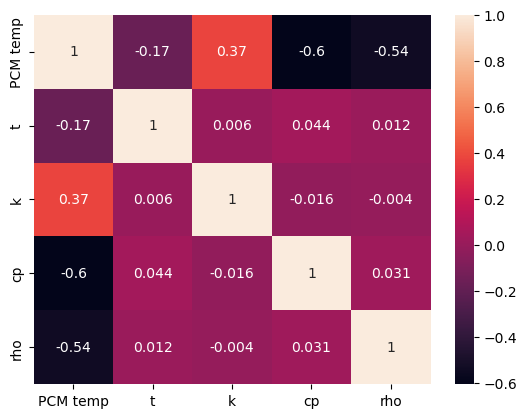

In [4]:
corr_table_1hr = pd.DataFrame({ 'PCM temp': PCMt_final_corr.ravel(), 't': t_corr.ravel(), 'k': k_corr.ravel(), 'cp': cp_corr.ravel(), 'rho': rho_corr.ravel()})

corr_matrix_1hr = corr_table_1hr.corr('pearson').round(3)
corr_matrix_1hr.style.background_gradient(cmap='coolwarm')

sns.heatmap(corr_matrix_1hr, annot=True)
